IMPORT MODULES

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import functions
import scipy.integrate
import scipy.optimize
import scipy.stats as stats
import math

CONSTANTS

In [14]:
global H_0, m_0, c
H_0 = 75 * 10**3 / (3.086*10**22) # s^-1
m_0 = -20.45
c = 299792458 # m/s

Investigate relationship between luminosity distance and redshift

_NOTE: We expect a  roughly linear relationship between distance and redshift, known as Hubble’s Law. However, if we extend the measurement to more distant objects, the relation becomes curved, and strongly dependent on the matter content of the Universe._

Text(0, 0.5, 'Redshift $z$')

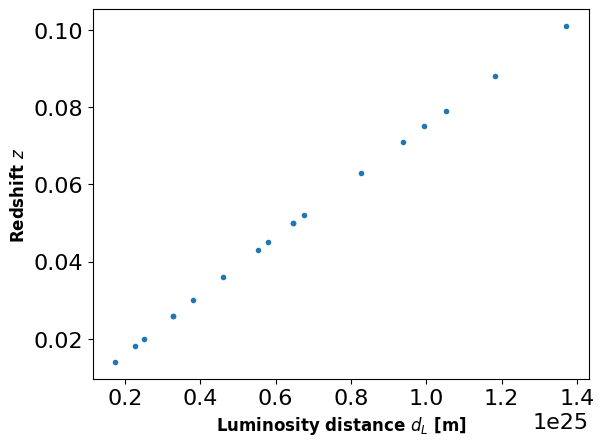

In [15]:
#reads data
name, redshift, eff_peak_mag, mag_err = functions.read_data('sn_data_milestone.txt')

#z < 0.1 data
low_redshift_indices = np.where(redshift<0.102)[0]
comoving_distance = functions.get_comoving_distance_low_z(redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1], H_0)
peak_flux, peak_flux_err = functions.get_flux(eff_peak_mag, mag_err, m_0)
d_L = functions.get_luminosity_distance(redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1], comoving_distance)
plt.scatter(d_L, redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1])
plt.xlabel('Luminosity distance $d_L$ [m]', weight = 'bold', fontsize = 12)
plt.ylabel('Redshift $z$', weight = 'bold', fontsize = 12)

Plotting effective magnitude against luminosity distance and fitting a curve to obtain the peak luminosity.

Text(0, 0.5, 'Effective magnitude $m_{eff}$')

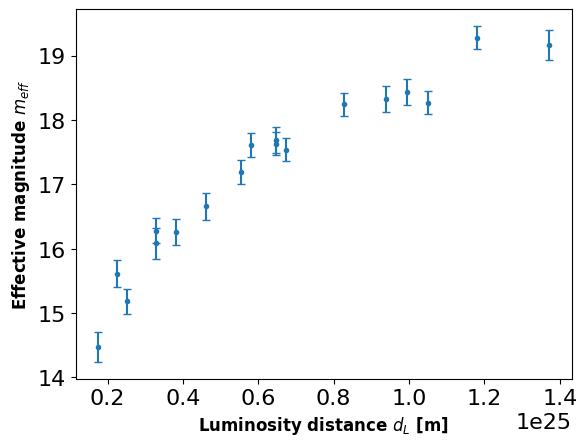

In [16]:
plt.errorbar(d_L, eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1], yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1], 
             ls='none', marker = 'o', capsize = 3)
plt.xlabel('Luminosity distance $d_L$ [m]', weight = 'bold', fontsize = 12)
plt.ylabel('Effective magnitude $m_{eff}$', weight = 'bold', fontsize = 12)

DoF = 17
Optimised parameters =  [3.26144341e+39] 

Covariance matrix = 
 [[1.94719522e+76]]


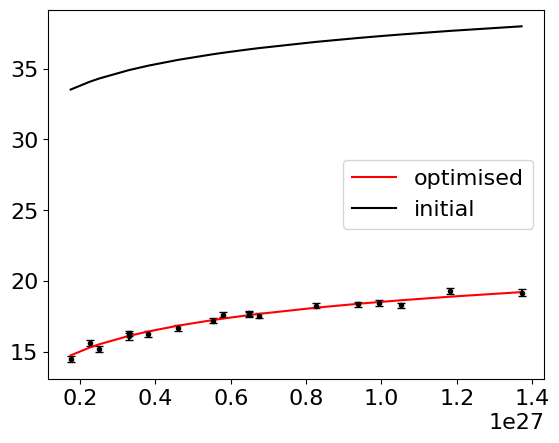

chi^2_min = 21.455532501736734
reduced chi^2 = 1.2620901471609844
$P(chi^2_min, DoF)$ = 0.206574238445178


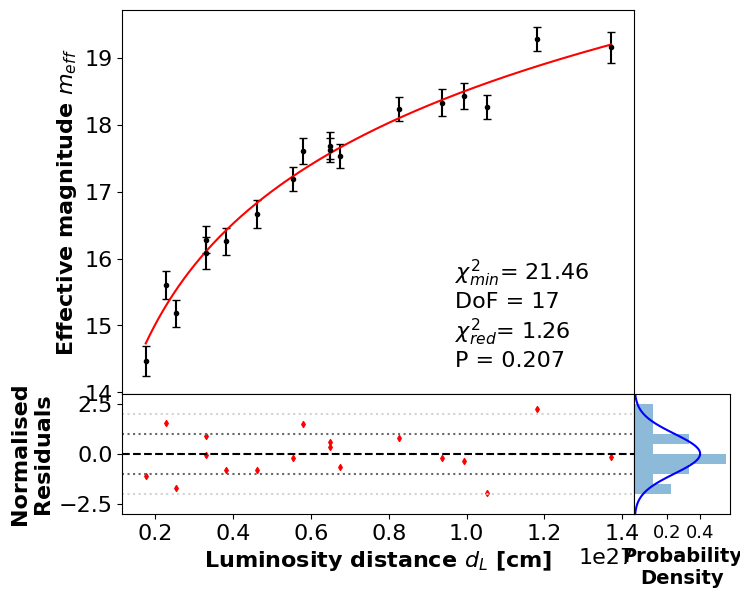

optimised parameter[0] = 3.261443407267811e+39 +/- 1.3954193699027837e+38
3.2614434072678105e+32
1.3954193699027836e+31


In [17]:
#chi squared fitting

xval = d_L*100 # cm
yval = eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1]
yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1]

def model_funct(x, *vals):
    return -2.5*np.log10(vals[0]/(4*np.pi*x**2)) + m_0

initial = np.array([1.0*10**32]) # Initial guess for fit parameters

plt.rcParams.update({'font.size': 16})

parameters = functions.automated_curve_fitting(xval, yval, yerr, model_funct, initial, 
                                               xlabel = 'Luminosity distance $d_L$ [cm]', 
                                               ylabel = 'Effective magnitude $m_{eff}$') #optimised parameters given in erg/s/Ang
L_peak = parameters[0][0]*10**-7 #W/Ang
L_peak_err = parameters[1][0]*10**-7 #W/Ang

print(L_peak)
print(L_peak_err)

DoF = 17
Optimised parameters =  [19263.73556048] 

Covariance matrix = 
 [[679312.11508908]]


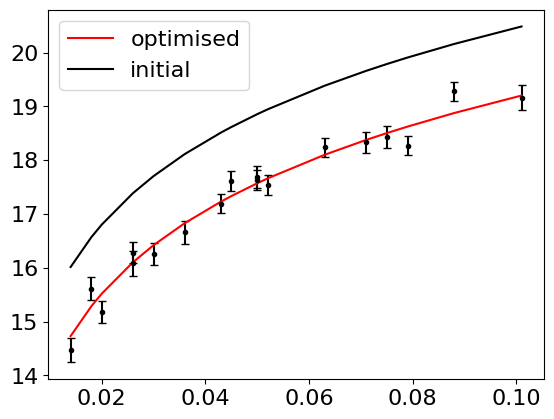

chi^2_min = 21.45553250173687
reduced chi^2 = 1.2620901471609922
$P(chi^2_min, DoF)$ = 0.2065742384451721


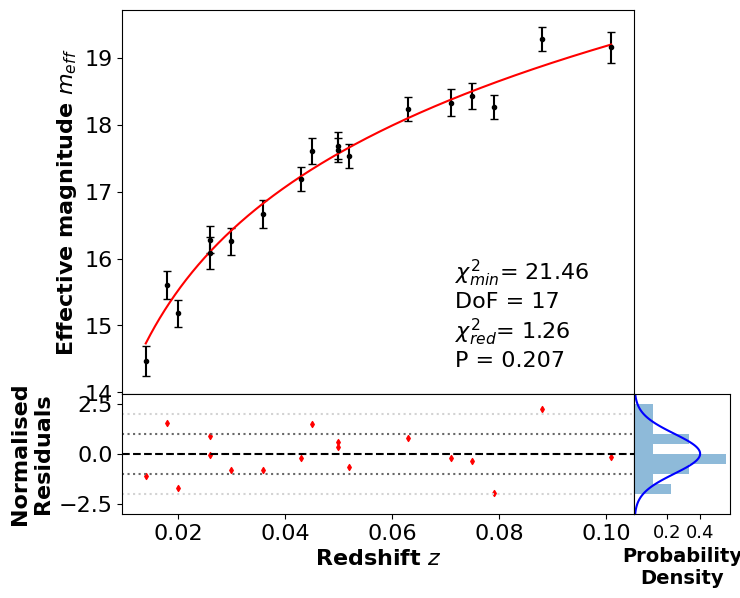

optimised parameter[0] = 19263.735560482088 +/- 824.2039280961209
3.2614432387867166e+32
1.3954169585804234e+31


In [18]:
#chi squared fitting - fitting L_peak*H_0**2

xval = redshift[low_redshift_indices[0]:low_redshift_indices[-1]+1]
yval = eff_peak_mag[low_redshift_indices[0]:low_redshift_indices[-1]+1]
yerr = mag_err[low_redshift_indices[0]:low_redshift_indices[-1]+1]

def model_funct(x, *vals):
    return -2.5*np.log10(np.array((vals[0]/(4*np.pi*(1+x)**2*(c*10**2)**2*x**2)), dtype = 'float')) + m_0

initial = np.array([1.0*10**39*H_0**2]) # Initial guess for fit parameters

plt.rcParams.update({'font.size': 16})

parameters = functions.automated_curve_fitting(xval, yval, yerr, model_funct, initial, 
                                               xlabel = 'Redshift $z$', 
                                               ylabel = 'Effective magnitude $m_{eff}$') #optimised parameters given in erg/s/Ang
L_peak = parameters[0][0]*10**-7/H_0**2 #W/Ang
L_peak_err = parameters[1][0]*10**-7/H_0**2 #W/Ang

print(L_peak) #Watts/Ang
print(L_peak_err) #Watts/Ang

Calculate Ω_Λ,0

81.33098369373201


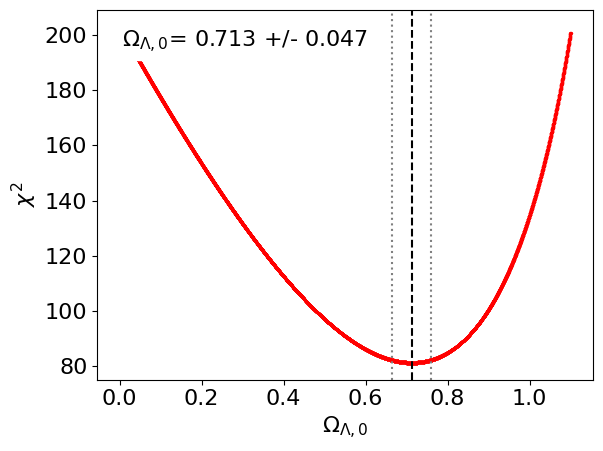

In [23]:
high_redshift_indices = np.where(redshift > 0.102)[0]

plt.rcParams.update({'font.size': 16})
omega_lambda, omega_lambda_err = functions.find_omega_lambda_and_error(redshift[high_redshift_indices[0]:high_redshift_indices[-1]+1], eff_peak_mag[high_redshift_indices[0]:high_redshift_indices[-1]+1], 
                                                             mag_err[high_redshift_indices[0]:high_redshift_indices[-1]+1], L_peak, H_0, m_0)


PLOTTING OBSERVED AND PREDICTED SUPERNOVA MAGNITUDES AGAINST REDSHIFT

(-3.0, 3.0)

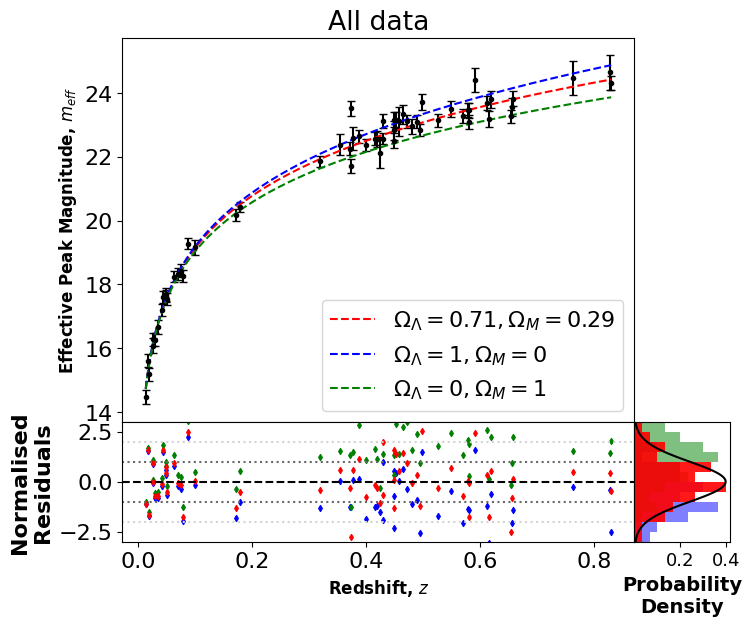

In [20]:
def model_funct(redshift, model_params):
    try:
        flux_predicted = L_peak/(4*np.pi*(1+redshift)**2*(functions.integrate_array(functions.comoving_distance_integrand, np.zeros(len(redshift.tolist())), redshift, args=(H_0, 0, model_params, None)))**2) #W/m^2/Ang
    except:
        flux_predicted = L_peak/(4*np.pi*(1+redshift)**2*(functions.integrate_array(functions.comoving_distance_integrand, [0], [redshift], args=(H_0, 0, model_params, None)))**2) #W/m^2/Ang
    flux_predicted = flux_predicted * 10**7 * 10**-4 #erg/s/cm^2/Angstrom
    mag_predicted = m_0 - 2.5*np.log10(flux_predicted) 
    return mag_predicted

plt.figure(1)
plt.figure(1).add_axes((0,0,0.8,0.8))
plt.errorbar(redshift, eff_peak_mag, yerr = mag_err, color = 'black', capsize = 3, marker='o', linestyle='None')
plt.plot(np.linspace(np.min(redshift), np.max(redshift), 1000), functions.mag_model(np.linspace(np.min(redshift), np.max(redshift), 1000), L_peak, H_0, m_0, 0, omega_lambda, None), label = f'$Ω_Λ = {np.round(omega_lambda, 2)}, Ω_M = {np.round(1-omega_lambda, 2)}$', color = 'red', linestyle = '--')
plt.plot(np.linspace(np.min(redshift), np.max(redshift), 1000), functions.mag_model(np.linspace(np.min(redshift), np.max(redshift), 1000), L_peak, H_0, m_0, 0, 1, None), label = '$Ω_Λ = 1, Ω_M = 0$', color = 'blue', linestyle = '--')
plt.plot(np.linspace(np.min(redshift), np.max(redshift), 1000), functions.mag_model(np.linspace(np.min(redshift), np.max(redshift), 1000), L_peak, H_0, m_0, 0, 0, None), label = '$Ω_Λ = 0, Ω_M = 1$', color = 'green', linestyle = '--')
plt.ylabel('Effective Peak Magnitude, $m_{eff}$', weight = 'bold', fontsize = 12)
plt.legend()
plt.title('All data')

plt.figure(1).add_axes((0,-0.25,0.8,0.25))
colours = ['blue', 'green', 'red']
omega_lambdas = [1, 0, omega_lambda]
plt.ylabel("""Normalised
Residuals""", weight = 'bold')
plt.ylim(-3, 3)
plt.axhline(y = 0, linestyle = '--', color = 'black')
plt.axhline(y = 1, linestyle = ':', color = 'dimgrey'); plt.axhline(y = -1, linestyle = ':', color = 'dimgrey')
plt.axhline(y = 2, linestyle = ':', color = 'lightgrey'); plt.axhline(y = -2, linestyle = ':', color = 'lightgrey')
plt.xlabel('Redshift, $z$', weight = 'bold', fontsize = 12)
for i in range(0, len(colours)):
        norm_residuals = functions.get_norm_residuals([omega_lambdas[i]], model_funct, redshift, eff_peak_mag, mag_err)
        plt.scatter(redshift, norm_residuals, color=colours[i], marker = 'd')

plt.figure(1).add_axes((0.8,-0.25,0.15,0.25))
plt.xticks([0.2,0.4], fontsize = 13)
mu = 0; variance = 1
sigma = math.sqrt(variance)    
y = np.linspace(mu - 3*sigma, mu + 3*sigma, 100)
plt.plot(stats.norm.pdf(y, mu, sigma), y, color = 'black')
plt.xlabel("""Probability
Density""", fontsize = 14, weight = 'bold')
plt.gca().set_yticks([])
plt.gca().invert_yaxis()

for i in range(0, len(colours)):
        norm_residuals = functions.get_norm_residuals([omega_lambdas[i]], model_funct, redshift, eff_peak_mag, mag_err)
        plt.hist(norm_residuals, bins=np.arange(-10, 10, 0.5), alpha = [0.5, 0.5, 0.9][i], density = True, orientation = 'horizontal', color = colours[i])
plt.ylim(-3, 3)

EXTENSIONS TO MILESTONE

k=-1
DoF = 58
Optimised parameters =  [0.66555378 0.31240182] 

Covariance matrix = 
 [[ 0.01335345 -0.00866199]
 [-0.00866199  0.00597509]]


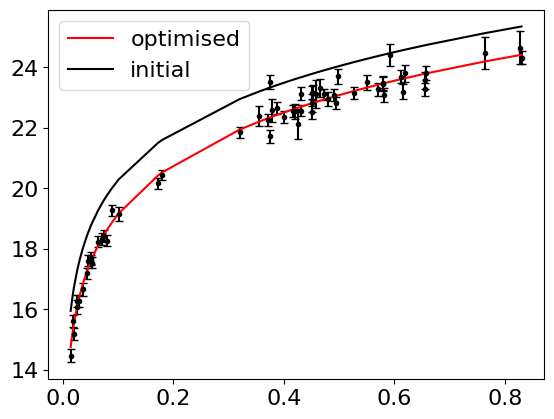

chi^2_min = 103.15744120205291
reduced chi^2 = 1.778576572449188
$P(chi^2_min, DoF)$ = 0.0002433282237565391


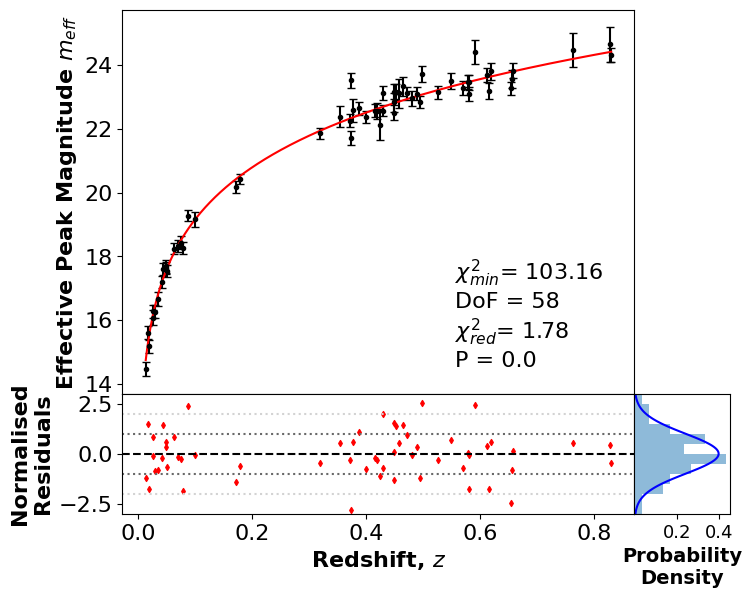

optimised parameter[0] = 0.665553775111497 +/- 0.11555710803914841
optimised parameter[1] = 0.3124018238734124 +/- 0.07729869822391723
omega_TOT = 0.9779555989849095 +/- 0.13902709795390122
k=0
DoF = 59
Optimised parameters =  [0.71638366] 

Covariance matrix = 
 [[0.00230343]]


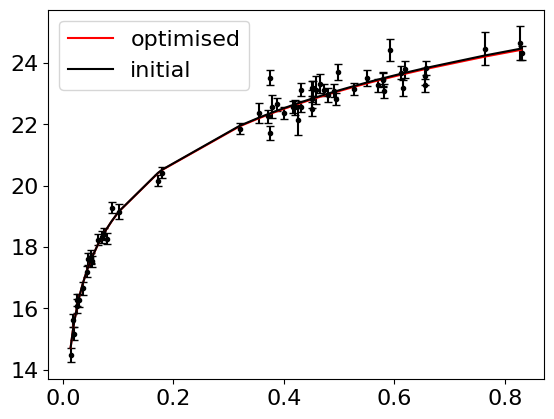

chi^2_min = 103.40157222514861
reduced chi^2 = 1.7525690207652307
$P(chi^2_min, DoF)$ = 0.0003137215780748281


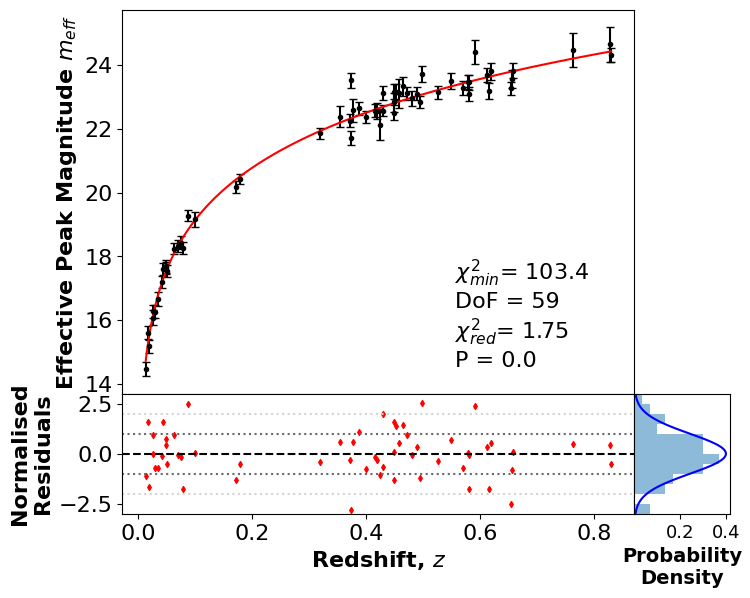

optimised parameter[0] = 0.7163836554032361 +/- 0.04799401167537486
k=1
DoF = 58


C:\Users\bradl\AppData\Local\Temp\ipykernel_7488\1994931129.py:24: RuntimeWarning: invalid value encountered in scalar power
  R_0 = ((k*c**2)/(H_0**2*(vals[0] + vals[1] - 1)))**0.5


Optimised parameters =  [0.73091112 0.26908898] 

Covariance matrix = 
 [[ 0.01308231 -0.00836035]
 [-0.00836035  0.0056928 ]]


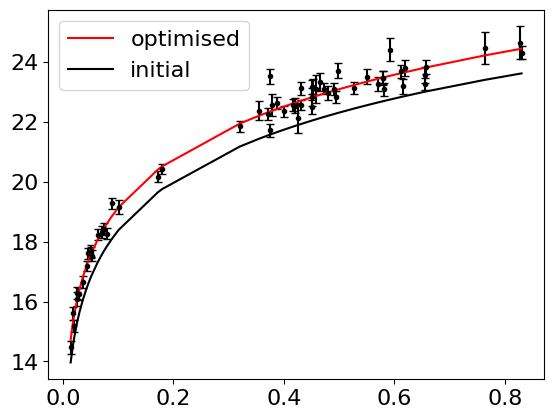

chi^2_min = 103.49618265710937
reduced chi^2 = 1.7844169423639547
$P(chi^2_min, DoF)$ = 0.0002244137697524124


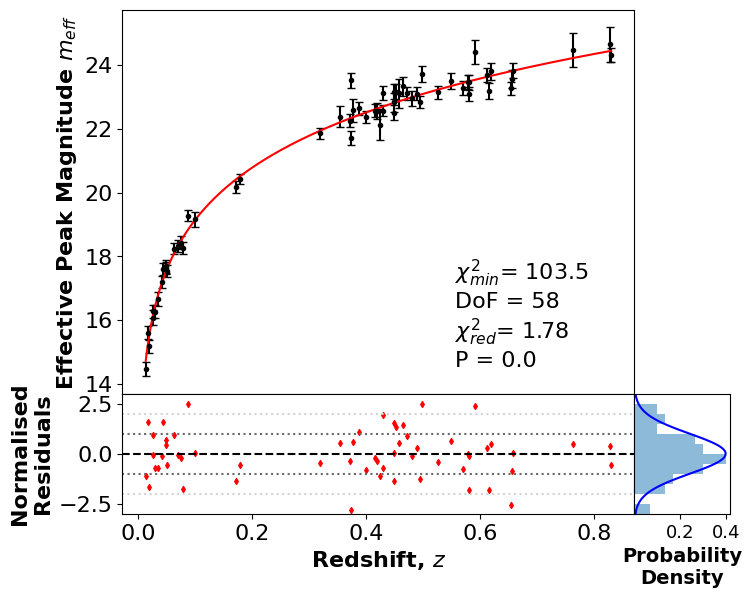

optimised parameter[0] = 0.7309111197982652 +/- 0.11437790821391111
optimised parameter[1] = 0.2690889788173411 +/- 0.07545062563169112
omega_TOT = 1.0000000986156063 +/- 0.13702227116641835


In [21]:
#chi squared fitting

xval = redshift
yval = eff_peak_mag
yerr = mag_err

plt.rcParams.update({'font.size': 16, 'lines.markersize': 3})

def model_funct(xs, *vals):
    try:
        if k==0:
            r_c = [(scipy.integrate.quad(functions.comoving_distance_integrand, 0, x, args=(H_0, k, vals[0], 1-vals[0]))[0]) for x in xs.tolist()]
        else:
            r_c = [(scipy.integrate.quad(functions.comoving_distance_integrand, 0, x, args=(H_0, k, vals[0], vals[1]))[0]) for x in xs.tolist()]
    except:
        if k==0:
            r_c = (scipy.integrate.quad(functions.comoving_distance_integrand, 0, xs, args=(H_0, k, vals[0], 1-vals[0]))[0])
        else:
            r_c = (scipy.integrate.quad(functions.comoving_distance_integrand, 0, xs, args=(H_0, k, vals[0], vals[1]))[0])

    if k == 0:
        S_k = r_c
    elif k == 1:
        R_0 = ((k*c**2)/(H_0**2*(vals[0] + vals[1] - 1)))**0.5
        S_k = R_0*np.sin(np.array(r_c)/R_0)
    elif k == -1:
        R_0 = ((k*c**2)/(H_0**2*(vals[0] + vals[1] - 1)))**0.5
        S_k = R_0*np.sinh(np.array(r_c)/R_0)

    try:
        flux_predicted = L_peak/(4*np.pi*(1+xs)**2*S_k**2) #W/m^2/Ang
    except:
        flux_predicted = L_peak/(4*np.pi*(1+xs)**2*np.array(S_k)**2)
    flux_predicted = flux_predicted * 10**7 * 10**-4 #erg/s/cm^2/Angstrom
    mag_predicted = m_0 - 2.5*np.log10(flux_predicted) 
    return mag_predicted

initials = [np.array([0.02, 0.3]), np.array([0.75]), np.array([1.5, 0.51])] # Initial guess for fit parameters
ks = [-1, 0, 1]

for i in range(0, len(ks)):
    k = ks[i]
    print(f'k={k}') 
    initial = initials[i]
    parameters = functions.automated_curve_fitting(xval, yval, yerr, model_funct, initial, 
                                                xlabel = 'Redshift, $z$', 
                                                ylabel = 'Effective Peak Magnitude $m_{eff}$') #optimised parameters given in erg/s/Ang
    if k == 1 or k==-1:
        print('omega_TOT = {} +/- {}'.format(np.sum(parameters[0]), np.sqrt(np.sum(parameters[1]**2))))